In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_iris

plt.style.use('seaborn')

In [ ]:
class Neural:
  def __init__(self):
    self.relu = torch.nn.ReLU()
    self.loss = torch.nn.CrossEntropyLoss()
    self.w0_shape = (4, 4)
    self.w1_shape = (4, 3)

  def forward(self, ip, w0, w1):
    x = torch.matmul(ip, w0)
    x = self.relu(x)
    x = torch.matmul(x, w1)
    return x

  def eval(self, chromosome, ip, label):
    w0 = torch.tensor(chromosome[:self.w0_shape[0] * 
                                 self.w0_shape[1]]).view(self.w0_shape[0], 
                                                         self.w0_shape[1])
    w1 = torch.tensor(chromosome[self.w0_shape[0] * 
                                 self.w0_shape[1]:]).view(self.w1_shape[0], 
                                                          self.w1_shape[1])
    x = self.forward(ip, w0, w1)
    return self.loss(x, label).item()

In [ ]:
class SBX:
  def __init__(self, iter, low, high, eta, pm, pc, p_size):
    self.p_size = p_size
    self.w0_shape = (4, 4)
    self.w1_shape = (4, 3)
    self.chromosome = None
    self.neural = Neural()
    self.data = load_iris()
    self.features = torch.tensor(self.data.data)
    self.label = torch.tensor(self.data.target)
    self.data_size = self.data.data.shape[0]
    self.epochs = iter
    self.low = low
    self.high = high
    self.answer = None
    self.eta = eta
    self.pm = pm
    self.pc = pc
    self.picked = []
    self.accuracy = []
    self.acc = None

  def solve(self):
    population = []
    for i in range(self.p_size):
        population.append(np.random.randn(self.w0_shape[1] * 
                                          self.w0_shape[0] + 
                                          self.w1_shape[1] * self.w1_shape[0]))

    for it in range(self.epochs):
      fitness = []
      if it and not it % 499:
        print(f"\t\t\t\t\tGENERATION: {it + 1}\n{np.array(population)}")
        new_line = '-' * 50
        print(new_line)
      for i in range(self.p_size):
        fitness.append(self.neural.eval(population[i], self.features, self.label))
      minfitness = min(fitness)
      idx = np.argmin(fitness)
      chromosome = population[idx]
      w0 = torch.tensor(chromosome[:self.w0_shape[0] * 
                                   self.w0_shape[1]]).view(self.w0_shape[0], 
                                                           self.w0_shape[1])
      w1 = torch.tensor(chromosome[self.w0_shape[0] * 
                                   self.w0_shape[1]:]).view(self.w1_shape[0], 
                                                            self.w1_shape[1])
      y = self.neural.forward(self.features, w0, w1)
      accuracy = torch.sum(torch.eq(torch.max(y, 1).indices, 
                                    self.label)).item() / self.data_size
      self.accuracy.append(accuracy)
      self.picked.append(minfitness)
      if self.answer is None or self.answer > minfitness:
        self.answer = minfitness
        self.acc = accuracy
        self.chromosome = population[idx]
      generation = []
      population = np.array(population)

      # tournament selection
      for i in range(self.p_size):
        idx1 = int(np.random.random()*1000) % self.p_size
        idx2 = int(np.random.random()*1000) % self.p_size
        while idx1 == idx2:
          idx1 = int(np.random.random()*1000) % self.p_size
          idx2 = int(np.random.random()*1000) % self.p_size

        parent1value = self.neural.eval(population[idx1], self.features,
                                        self.label)
        parent2value = self.neural.eval(population[idx2], self.features, 
                                        self.label)

        if parent1value <= parent2value:
          generation.append(population[idx1])
        else:
          generation.append(population[idx2])

      generation = np.array(generation)
      generationbeforemutation = []

      # crossover
      for i in range(int(len(generation)/2)):
        idx1 = int(np.random.random()*1000) % self.p_size
        idx2 = int(np.random.random()*1000) % self.p_size
        while idx1 == idx2:
          idx1 = int(np.random.random()*1000) % self.p_size
          idx2 = int(np.random.random()*1000) % self.p_size

        if np.random.random() > self.pc:
          continue

        u = [np.random.random()
        for j in range(self.w0_shape[1] * self.w0_shape[0] +
                       self.w1_shape[1] * self.w1_shape[0])]
        beta = []
        eta = self.eta+1
        for ui in u:
          if ui <= 0.5:
            beta.append((2*ui)**(1/eta))
          else:
            beta.append(1/((2*(1-ui))**(1/eta)))
        beta = np.array(beta)
        x1 = (0.5*((1+beta)*np.array(generation[idx1])+(1-beta)
        *np.array(generation[idx2])))
        x2 = (0.5*((1-beta)*np.array(generation[idx1])+(1+beta)
        *np.array(generation[idx2])))

        generationbeforemutation.append(x1)
        generationbeforemutation.append(x2)

      # mutation
      generationaftermutation = list(population)
      for i in range(len(generationbeforemutation)):
        newval = generationbeforemutation[i]
        for j in range(self.w0_shape[1] * self.w0_shape[0] + 
                       self.w1_shape[1] * self.w1_shape[0]):
          if np.random.random() <= self.pm:
            delta = None
            r = np.random.random()
            eta = self.eta+1
            if r < 0.5:
              delta = ((2*r)**(1/eta))-1
            else:
              delta = 1-((2*(1-r))**(1/eta))
            newval[j] = generationbeforemutation[i][j] + (self.high - self.low) * delta
          newval[j] = max(self.low, min(newval[j], self.high))
        generationaftermutation.append(newval)
      generationaftermutation = sorted(generationaftermutation, 
        key=lambda x: self.neural.eval(x, self.features, 
                                       self.label))[:self.p_size]
      population = generationaftermutation

					GENERATION: 500
[[-0.68280691  0.96807732 -0.5380395   0.47019816 -0.53871492  0.98737045
   0.35579096  0.86632957  1.         -0.96835183  1.         -0.73837237
   0.95039868 -0.07272067  1.         -0.66155668  0.92689113 -0.99999491
   0.88664922 -0.48668954 -0.31673611 -1.         -0.99735796  0.47531203
   0.97260338  1.         -0.36958893 -1.        ]
 [-0.68280691  0.96807586 -0.5746919   0.47019816 -0.54424652  0.9873698
   0.35579096  0.86632957  1.         -0.96835392  1.         -0.73837859
   1.         -0.04867695  0.97137068 -0.66155917  0.92868799 -0.99999491
   0.8866565  -0.48642849 -0.31673611 -1.         -0.99735796  0.45555956
   0.97260338  1.         -0.37217748 -1.        ]
 [-0.68280691  0.96807586 -0.54553772  0.47019816 -0.54424652  0.9873698
   0.35579096  0.86632957  1.         -0.96835392  1.         -0.73837859
   0.95055686 -0.07272067  1.         -0.66155917  0.92868799 -0.99999491
   0.8866565  -0.48642849 -0.31673611 -1.         -0.99735796  0.

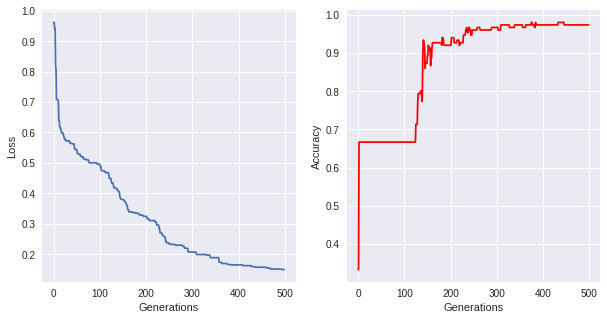

In [ ]:
if __name__ == '__main__':
  low = -1
  high = 1
  g = SBX(500, low, high, 15, 0.2, 0.8, 6)
  g.solve()
  print("Final Loss: ", g.answer)
  print("Accuracy after training: ", g.acc)
  fig = plt.figure(figsize=(10, 5))
  ax = fig.subplots(nrows=1, ncols=2)
  ax[0].plot(g.picked)
  ax[0].set_xlabel('Generations')
  ax[0].set_ylabel('Loss')
  ax[1].plot(g.accuracy, color='r')
  ax[1].set_xlabel('Generations')
  ax[1].set_ylabel('Accuracy')
  plt.show()